In [1]:
import matplotlib.pyplot as plt
from astropy import units as u
from poliastro.bodies import Earth, Mars, Sun, Moon
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter2D
from poliastro.plotting import OrbitPlotter3D
import pandas as pd
from utility.utils import *
# style seaborn
plt.style.use("seaborn")

In [2]:
R_moon = Moon.R_mean # m
R_moon_km = R_moon / 1000
R_moon

<Quantity 1737400. m>

In [3]:
# Data for Mars at J2000 from JPL HORIZONS
a = R_moon+50 * u.km
ecc = 0. * u.one
inc = 0. * u.deg
raan = 0. * u.deg
argp = 0. * u.deg
nu = 0. * u.deg

orb = Orbit.from_classical(Moon, a, ecc, inc, raan, argp, nu)

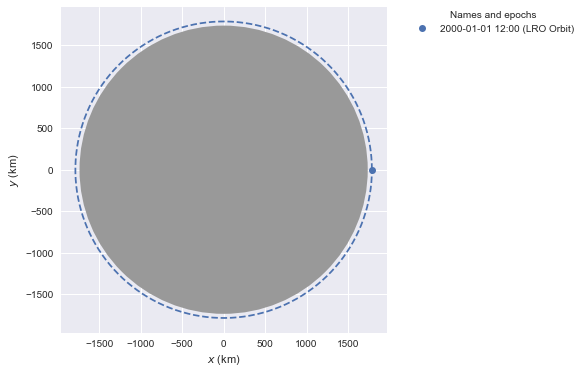

In [4]:
orb.plot(label='LRO Orbit' )
plt.show()

In [17]:
from poliastro.twobody.propagation import cowell as cowell
from poliastro.twobody.propagation import farnocchia as farnocchia
from poliastro.twobody.propagation import vallado as vallado
from poliastro.twobody.propagation import mikkola as mikkola
from poliastro.twobody.propagation import markley as markley
from poliastro.twobody.propagation import pimienta as pimienta
from poliastro.twobody.propagation import gooding as gooding
from poliastro.twobody.propagation import danby as danby
from poliastro.core.perturbations import J2_perturbation


In [18]:
############################################
dt = 10
############################################
df = pd.read_csv(f'DATA/ephemeris sat/inclination zero/{dt} step size.csv', header=3, sep=';') 
real_Latitudes, real_Longitudes, real_Altitudes = df['Lat (deg)'], df['Lon (deg)'], df['Alt (km)']
real_Vxs,real_Vys,real_Vzs = df['x (km/sec)'], df['y (km/sec)'],df['z (km/sec)']

real_X, real_Y, real_Z = [], [], []
for i in range(len(df)):
    altitude = real_Altitudes[i]
    latitude = real_Latitudes[i]
    longitude = real_Longitudes[i]
    x, y, z = spherical2cartesian(altitude, latitude, longitude)
    real_X.append(x)
    real_Y.append(y)
    real_Z.append(z)
real_X, real_Y, real_Z = np.array(real_X),np.array(real_Y),np.array(real_Z)

# Initial State Vector:
x, y, z = real_X[0], real_Y[0], real_Z[0]
vx, vy, vz = real_Vxs[0], real_Vys[0], real_Vzs[0]

In [47]:
r = np.array([x,y,z])*u.km
v = np.array([vx,vy,vz])*u.km/u.s
tofs = np.linspace(5,5,1)*u.s
print(tofs)

[5.] s


In [48]:
rr2, vv2 = cowell(Earth.k, r, v, tofs=tofs, ad=J2_perturbation, J2=Moon.J2.value , R=Moon.R.to(u.km).value)
rr1, vv1 = cowell(Earth.k, r, v, tofs=tofs)

In [49]:
print(rr1.to_value())
print(vv1.to_value())

[[-1506.96917176  -958.29896618     0.        ]]
[[ 1.4097159  -1.06793944  0.        ]]


In [50]:
print(rr2.to_value())
print(vv2.to_value())

[[-1506.96917176  -958.29896618     0.        ]]
[[ 1.4097159  -1.06793944  0.        ]]


In [52]:
initial = Orbit.from_vectors(Moon, r, v)

In [53]:
final = initial.propagate(5*u.s, method=cowell, ad=J2_perturbation, J2=Moon.J2.value, R=Moon.R.to(u.km).value)

In [54]:
final.r

<Quantity [-1508.27192825,  -959.12176042,     0.        ] km>